In [40]:
!pip install tensorflow pillow matplotlib numpy

In [41]:
images_path, captions_file = explore_kaggle_dataset()

🔍 EXPLORING KAGGLE DATASET STRUCTURE
📁 Available datasets in /kaggle/input:
  1. flickr8k

✅ Found Flickr datasets: ['flickr8k']

📂 Exploring: /kaggle/input/flickr8k
📁 flickr8k/
  📝 captions.txt
     ✅ This looks like the main captions file!
  📄 captions.txt
  📁 Images/
    ✅ Found 8091 images here!
    📄 3226254560_2f8ac147ea.jpg
    📄 214543992_ce6c0d9f9b.jpg
    📄 2366643786_9c9a830db8.jpg
    ... and 8088 more files

🎯 DETECTION RESULTS:
Images path: /kaggle/input/flickr8k/Images
Captions file: /kaggle/input/flickr8k/captions.txt


In [45]:

# This version avoids all GPU/cuDNN compatibility issues

import os
import string
import pickle
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from PIL import Image
import warnings
warnings.filterwarnings('ignore')

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.applications.xception import Xception
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Dense, SimpleRNN, Embedding, Dropout, add

print("🚀 SIMPLE IMAGE CAPTION GENERATOR (CPU-SAFE)")
print("=" * 60)
print("TensorFlow version:", tf.__version__)

# Force CPU usage to avoid GPU issues (optional)
# tf.config.set_visible_devices([], 'GPU')

# Dataset paths
IMAGES_PATH = "/kaggle/input/flickr8k/Images"
CAPTIONS_FILE = "/kaggle/input/flickr8k/captions.txt"

def load_captions():
    """Load captions with simple parsing"""
    print(f"\n📖 Loading captions from: {CAPTIONS_FILE}")
    
    try:
        # Read as CSV
        df = pd.read_csv(CAPTIONS_FILE)
        print(f"✅ Loaded CSV: {df.shape}")
        print(f"Columns: {list(df.columns)}")
        
        # Use first two columns
        img_col = df.columns[0]
        cap_col = df.columns[1]
        
        descriptions = {}
        for _, row in df.iterrows():
            img_name = str(row[img_col]).strip()
            caption = str(row[cap_col]).strip()
            
            if 'nan' in [img_name, caption]:
                continue
            
            img_id = os.path.splitext(img_name)[0]
            if img_id not in descriptions:
                descriptions[img_id] = []
            descriptions[img_id].append(caption)
        
        print(f"✅ Processed {len(descriptions)} images")
        return descriptions
        
    except Exception as e:
        print(f"❌ Error: {e}")
        return {}

def clean_captions(descriptions):
    """Simple caption cleaning"""
    print(f"🧹 Cleaning captions...")
    
    cleaned = {}
    for img_id, captions in descriptions.items():
        cleaned[img_id] = []
        for caption in captions:
            # Simple cleaning
            words = caption.lower().split()
            words = [w for w in words if w.isalpha() and len(w) > 1]
            cleaned_caption = ' '.join(words)
            if len(cleaned_caption) > 0:
                cleaned[img_id].append(cleaned_caption)
    
    # Remove images with no valid captions
    cleaned = {k: v for k, v in cleaned.items() if v}
    print(f"✅ Cleaned: {len(cleaned)} images")
    return cleaned

def extract_features_simple(descriptions, max_images=2000):
    """Extract features for available images"""
    print(f"🖼️ Extracting features (max {max_images})...")
    
    model = Xception(include_top=False, pooling='avg')
    features = {}
    
    # Get available images
    if not os.path.exists(IMAGES_PATH):
        print(f"❌ Images folder not found")
        return {}
    
    image_files = [f for f in os.listdir(IMAGES_PATH) if f.lower().endswith(('.jpg', '.jpeg', '.png'))]
    print(f"Found {len(image_files)} images")
    
    # Process only images we have captions for
    processed = 0
    for img_file in image_files:
        if processed >= max_images:
            break
        
        img_id = os.path.splitext(img_file)[0]
        if img_id not in descriptions:
            continue
        
        try:
            img_path = os.path.join(IMAGES_PATH, img_file)
            image = Image.open(img_path)
            
            if image.mode != 'RGB':
                image = image.convert('RGB')
            
            image = image.resize((299, 299))
            image = np.array(image)
            image = np.expand_dims(image, axis=0)
            image = image / 127.5 - 1.0
            
            feature = model.predict(image, verbose=0)
            features[img_id] = feature
            processed += 1
            
            if processed % 50 == 0:
                print(f"   Processed {processed}/{max_images}")
        
        except Exception as e:
            if processed < 5:
                print(f"Error with {img_file}: {e}")
    
    print(f"✅ Extracted features for {len(features)} images")
    return features

def create_simple_model(vocab_size, max_length):
    """Create a simple model without LSTM complications"""
    print(f"🏗️ Building simple model...")
    
    # Image features
    input1 = Input(shape=(2048,))
    fe1 = Dense(256, activation='relu')(input1)
    fe2 = Dropout(0.3)(fe1)
    
    # Text input
    input2 = Input(shape=(max_length,))
    se1 = Embedding(vocab_size, 256)(input2)
    se2 = Dropout(0.3)(se1)
    # Use SimpleRNN instead of LSTM to avoid cuDNN issues
    se3 = SimpleRNN(256)(se2)
    
    # Combine
    combined = add([fe2, se3])
    dense1 = Dense(256, activation='relu')(combined)
    dense2 = Dropout(0.3)(dense1)
    output = Dense(vocab_size, activation='softmax')(dense2)
    
    model = Model(inputs=[input1, input2], outputs=output)
    model.compile(
        loss='categorical_crossentropy',
        optimizer='adam',
        metrics=['accuracy']
    )
    
    print("✅ Simple model created")
    return model

def prepare_data(descriptions, features):
    """Prepare training data"""
    print(f"📊 Preparing training data...")
    
    # Create tokenizer
    all_captions = []
    for captions in descriptions.values():
        for caption in captions:
            all_captions.append('start ' + caption + ' end')
    
    tokenizer = Tokenizer()
    tokenizer.fit_on_texts(all_captions)
    vocab_size = len(tokenizer.word_index) + 1
    
    # Calculate max length
    max_length = max(len(caption.split()) for caption in all_captions)
    max_length = min(max_length, 20)  # Limit to avoid memory issues
    
    print(f"Vocab size: {vocab_size}")
    print(f"Max length: {max_length}")
    
    # Create sequences
    X1, X2, y = [], [], []
    
    for img_id, captions in descriptions.items():
        if img_id not in features:
            continue
        
        feature = features[img_id][0]
        
        for caption in captions:
            caption = 'start ' + caption + ' end'
            seq = tokenizer.texts_to_sequences([caption])[0]
            
            for i in range(1, len(seq)):
                in_seq = seq[:i]
                out_word = seq[i]
                
                # Pad sequence
                in_seq = pad_sequences([in_seq], maxlen=max_length, padding='post')[0]
                out_word = to_categorical([out_word], num_classes=vocab_size)[0]
                
                X1.append(feature)
                X2.append(in_seq)
                y.append(out_word)
    
    X1 = np.array(X1)
    X2 = np.array(X2)
    y = np.array(y)
    
    print(f"Training data: {X1.shape[0]} samples")
    return tokenizer, vocab_size, max_length, [X1, X2], y

def generate_simple_caption(model, tokenizer, photo, max_length):
    """Generate caption"""
    in_text = 'start'
    for _ in range(max_length):
        seq = tokenizer.texts_to_sequences([in_text])[0]
        seq = pad_sequences([seq], maxlen=max_length, padding='post')
        pred = model.predict([photo, seq], verbose=0)
        pred = np.argmax(pred)
        
        word = None
        for w, idx in tokenizer.word_index.items():
            if idx == pred:
                word = w
                break
        
        if word is None or word == 'end':
            break
        
        in_text += ' ' + word
    
    return in_text.replace('start ', '')

# 🚀 MAIN EXECUTION
print("\n" + "="*60)
print("STARTING SIMPLE CAPTION GENERATOR")
print("="*60)

# Step 1: Load data
descriptions = load_captions()

if not descriptions:
    print("❌ Could not load captions!")
else:
    print(f"✅ Loaded {len(descriptions)} image descriptions")
    
    # Step 2: Clean
    descriptions = clean_captions(descriptions)
    
    # Step 3: Extract features
    features = extract_features_simple(descriptions, max_images=500)
    
    if not features:
        print("❌ Could not extract features!")
    else:
        # Filter descriptions to match features
        descriptions = {k: v for k, v in descriptions.items() if k in features}
        print(f"✅ Final dataset: {len(descriptions)} images")
        
        # Step 4: Prepare data
        tokenizer, vocab_size, max_length, X_train, y_train = prepare_data(descriptions, features)
        
        # Step 5: Train model
        print(f"\n🎓 Training model...")
        model = create_simple_model(vocab_size, max_length)
        
        # Split data
        split_idx = int(len(X_train[0]) * 0.8)
        X_train_split = [X_train[0][:split_idx], X_train[1][:split_idx]]
        y_train_split = y_train[:split_idx]
        X_val = [X_train[0][split_idx:], X_train[1][split_idx:]]
        y_val = y_train[split_idx:]
        
        print(f"Training samples: {len(X_train_split[0])}")
        print(f"Validation samples: {len(X_val[0])}")
        
        # Train
        epochs = 5
        for epoch in range(epochs):
            print(f"\n📚 Epoch {epoch+1}/{epochs}")
            
            history = model.fit(
                X_train_split, y_train_split,
                epochs=1,
                batch_size=32,
                validation_data=(X_val, y_val),
                verbose=1
            )
            
            # Save model
            model_path = f"/kaggle/working/simple_model_epoch_{epoch+1}.h5"
            model.save(model_path)
            print(f"💾 Saved: {model_path}")
            
            # Test
            if descriptions:
                test_id = list(descriptions.keys())[0]
                test_feature = features[test_id]
                generated = generate_simple_caption(model, tokenizer, test_feature, max_length)
                actual = descriptions[test_id][0]
                
                print(f"🧪 Generated: '{generated}'")
                print(f"🎯 Actual: '{actual}'")
        
        # Save artifacts
        print(f"\n💾 Saving artifacts...")
        with open('/kaggle/working/simple_tokenizer.pkl', 'wb') as f:
            pickle.dump(tokenizer, f)
        
        print(f"\n🎉 TRAINING COMPLETED!")
        
        

print(f"\n🔚 COMPLETED!")

🚀 SIMPLE IMAGE CAPTION GENERATOR (CPU-SAFE)
TensorFlow version: 2.18.0

STARTING SIMPLE CAPTION GENERATOR

📖 Loading captions from: /kaggle/input/flickr8k/captions.txt
✅ Loaded CSV: (40455, 2)
Columns: ['image', 'caption']
✅ Processed 8091 images
✅ Loaded 8091 image descriptions
🧹 Cleaning captions...
✅ Cleaned: 8091 images
🖼️ Extracting features (max 500)...
Found 8091 images
   Processed 50/500
   Processed 100/500
   Processed 150/500
   Processed 200/500
   Processed 250/500
   Processed 300/500
   Processed 350/500
   Processed 400/500
   Processed 450/500
   Processed 500/500
✅ Extracted features for 500 images
✅ Final dataset: 500 images
📊 Preparing training data...
Vocab size: 2244
Max length: 20
Training data: 25473 samples

🎓 Training model...
🏗️ Building simple model...
✅ Simple model created
Training samples: 20378
Validation samples: 5095

📚 Epoch 1/5
637/637 ━━━━━━━━━━━━━━━━━━━━ 11s 10ms/step - accuracy: 0.0891 - loss: 5.9877 - val_accuracy: 0.0991 - val_loss: 5.9068
💾 Sa


🎨 FINAL RESULT:
🤖 Generated: boy
👨‍💻 Actual: little girl in pajamas runs down hall with hardwood floors


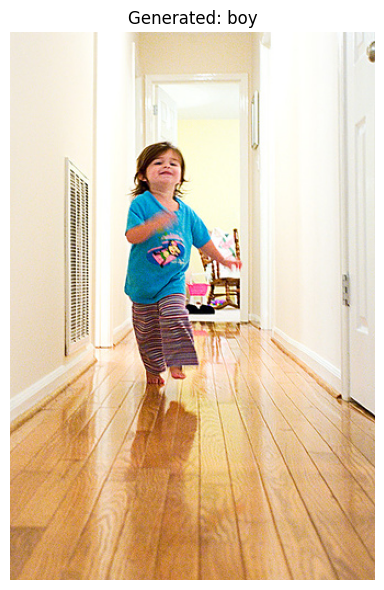

In [48]:
def show_result():
            test_id = list(descriptions.keys())[32]
            test_feature = features[test_id]
            generated = generate_simple_caption(model, tokenizer, test_feature, max_length)
            actual = descriptions[test_id][0]
            
            print(f"\n🎨 FINAL RESULT:")
            print(f"🤖 Generated: {generated}")
            print(f"👨‍💻 Actual: {actual}")
            
            # Show image
            try:
                for ext in ['.jpg', '.jpeg', '.png']:
                    img_path = os.path.join(IMAGES_PATH, f"{test_id}{ext}")
                    if os.path.exists(img_path):
                        img = Image.open(img_path)
                        plt.figure(figsize=(8, 6))
                        plt.imshow(img)
                        plt.axis('off')
                        plt.title(f"Generated: {generated}", fontsize=12)
                        plt.tight_layout()
                        plt.show()
                        break
            except Exception as e:
                print(f"Could not show image: {e}")
        
show_result()

🚀 SIMPLE IMAGE CAPTION GENERATOR (CPU-SAFE)
TensorFlow version: 2.18.0

STARTING SIMPLE CAPTION GENERATOR

📖 Loading captions from: /kaggle/input/flickr8k/captions.txt
✅ Loaded CSV: (40455, 2)
Columns: ['image', 'caption']
✅ Processed 8091 images
✅ Loaded 8091 image descriptions
🧹 Cleaning captions...
✅ Cleaned: 8091 images
🖼️ Extracting features (max 500)...
Found 8091 images
   Processed 100/500
   Processed 200/500
   Processed 300/500
   Processed 400/500
   Processed 500/500
✅ Extracted features for 500 images
✅ Final dataset: 500 images
📊 Preparing training data...
Vocab size: 2244
Max length: 20
Training data: 25473 samples

🎓 Training model...
🏗️ Building simple model...
✅ Simple model created
Training samples: 20378
Validation samples: 5095

📚 Epoch 1/3
637/637 ━━━━━━━━━━━━━━━━━━━━ 12s 10ms/step - accuracy: 0.0858 - loss: 6.0079 - val_accuracy: 0.0991 - val_loss: 5.7581
💾 Saved: /kaggle/working/simple_model_epoch_1.h5
🧪 Generated: 'start'
🎯 Actual: 'little girl covered in pain

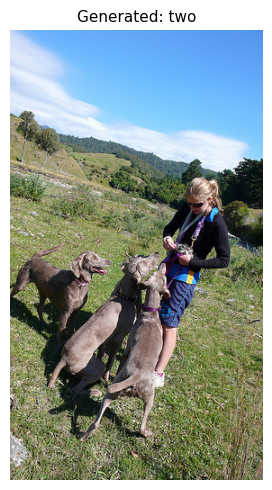


📸 Test 2/3 - Image: 3254662117_b2e7dede6e
🤖 Generated: 'man'
👨‍💻 Actual captions:
   1: 'two guys with long hair standing in front of window'
   2: 'two long haired boys are by white window'


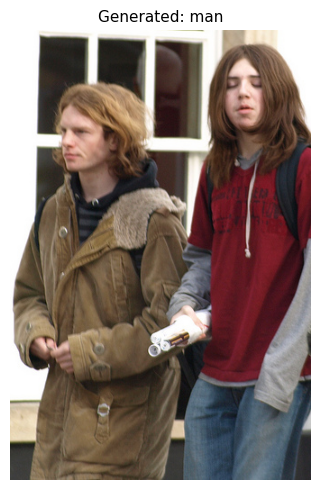


📸 Test 3/3 - Image: 2443229844_277cded27d
🤖 Generated: 'man'
👨‍💻 Actual captions:
   1: 'child in bright blue sweatshirt playing in the woods with red wagon'
   2: 'child wearing blue sweatshirt makes funny face standing next to wagon'


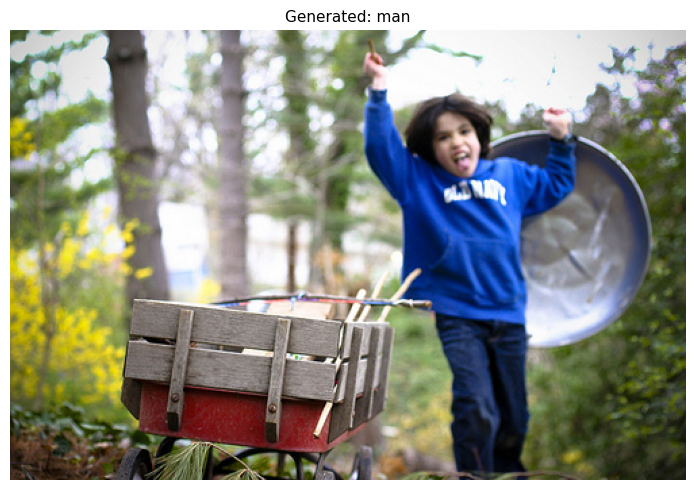


📊 MODEL PERFORMANCE EVALUATION
----------------------------------------
✅ Evaluated on 50 images
📏 Average generated caption length: 1.0 words
📏 Average actual caption length: 8.5 words
🎯 Average word overlap: 2.59%

🎮 INTERACTIVE DEMO
------------------------------
Available test images:
  1. 1002674143_1b742ab4b8
  2. 102351840_323e3de834
  3. 1075881101_d55c46bece
  4. 109202756_b97fcdc62c
  5. 1100214449_d10861e633
  6. 111537217_082a4ba060
  7. 113678030_87a6a6e42e
  8. 1153704539_542f7aa3a5
  9. 1206506157_c7956accd5
  10. 1236964638_1808784a3c

🎯 Testing random selections...

🎲 Random test 1: 113678030_87a6a6e42e

🖼️ CAPTIONING IMAGE: 113678030_87a6a6e42e


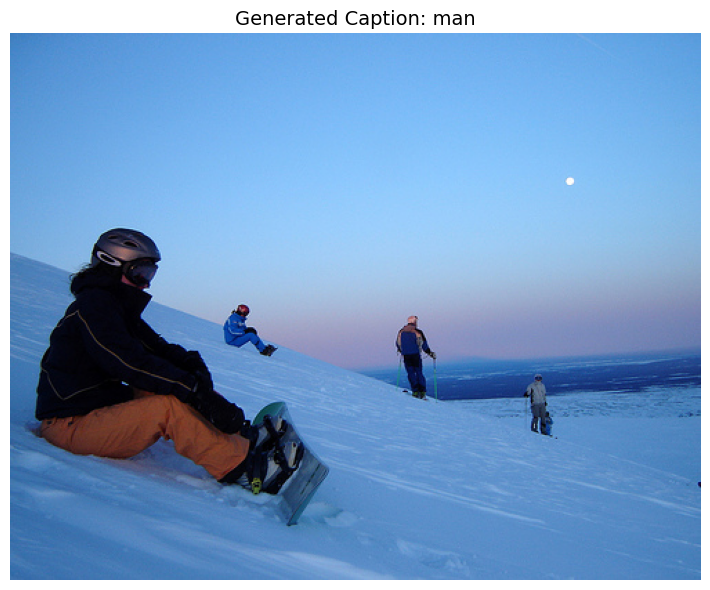

🤖 Generated Caption: 'man'

🎲 Random test 2: 109202756_b97fcdc62c

🖼️ CAPTIONING IMAGE: 109202756_b97fcdc62c


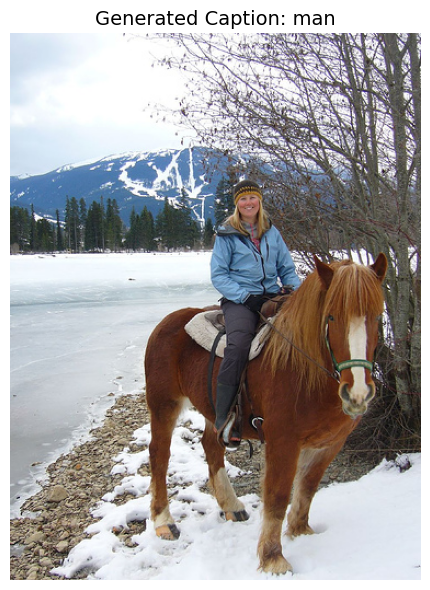

🤖 Generated Caption: 'man'

🎲 Random test 3: 1002674143_1b742ab4b8

🖼️ CAPTIONING IMAGE: 1002674143_1b742ab4b8


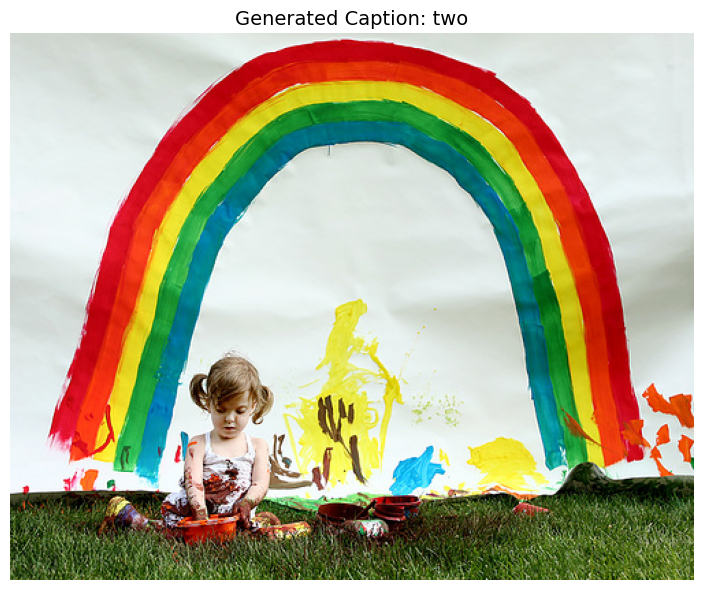

🤖 Generated Caption: 'two'

🎊 PIPELINE COMPLETE! ALL FUNCTIONS READY TO USE!

🔚 COMPLETED!


In [46]:
# SIMPLE IMAGE CAPTION GENERATOR - KAGGLE SAFE VERSION
# This version avoids all GPU/cuDNN compatibility issues

import os
import string
import pickle
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from PIL import Image
import warnings
warnings.filterwarnings('ignore')

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.applications.xception import Xception
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Dense, SimpleRNN, Embedding, Dropout, add

print("🚀 SIMPLE IMAGE CAPTION GENERATOR (CPU-SAFE)")
print("=" * 60)
print("TensorFlow version:", tf.__version__)

# Force CPU usage to avoid GPU issues (optional)
# tf.config.set_visible_devices([], 'GPU')

# Dataset paths
IMAGES_PATH = "/kaggle/input/flickr8k/Images"
CAPTIONS_FILE = "/kaggle/input/flickr8k/captions.txt"

def load_captions():
    """Load captions with simple parsing"""
    print(f"\n📖 Loading captions from: {CAPTIONS_FILE}")
    
    try:
        # Read as CSV
        df = pd.read_csv(CAPTIONS_FILE)
        print(f"✅ Loaded CSV: {df.shape}")
        print(f"Columns: {list(df.columns)}")
        
        # Use first two columns
        img_col = df.columns[0]
        cap_col = df.columns[1]
        
        descriptions = {}
        for _, row in df.iterrows():
            img_name = str(row[img_col]).strip()
            caption = str(row[cap_col]).strip()
            
            if 'nan' in [img_name, caption]:
                continue
            
            img_id = os.path.splitext(img_name)[0]
            if img_id not in descriptions:
                descriptions[img_id] = []
            descriptions[img_id].append(caption)
        
        print(f"✅ Processed {len(descriptions)} images")
        return descriptions
        
    except Exception as e:
        print(f"❌ Error: {e}")
        return {}

def clean_captions(descriptions):
    """Simple caption cleaning"""
    print(f"🧹 Cleaning captions...")
    
    cleaned = {}
    for img_id, captions in descriptions.items():
        cleaned[img_id] = []
        for caption in captions:
            # Simple cleaning
            words = caption.lower().split()
            words = [w for w in words if w.isalpha() and len(w) > 1]
            cleaned_caption = ' '.join(words)
            if len(cleaned_caption) > 0:
                cleaned[img_id].append(cleaned_caption)
    
    # Remove images with no valid captions
    cleaned = {k: v for k, v in cleaned.items() if v}
    print(f"✅ Cleaned: {len(cleaned)} images")
    return cleaned

def extract_features_simple(descriptions, max_images=2000):
    """Extract features for available images"""
    print(f"🖼️ Extracting features (max {max_images})...")
    
    model = Xception(include_top=False, pooling='avg')
    features = {}
    
    # Get available images
    if not os.path.exists(IMAGES_PATH):
        print(f"❌ Images folder not found")
        return {}
    
    image_files = [f for f in os.listdir(IMAGES_PATH) if f.lower().endswith(('.jpg', '.jpeg', '.png'))]
    print(f"Found {len(image_files)} images")
    
    # Process only images we have captions for
    processed = 0
    for img_file in image_files:
        if processed >= max_images:
            break
        
        img_id = os.path.splitext(img_file)[0]
        if img_id not in descriptions:
            continue
        
        try:
            img_path = os.path.join(IMAGES_PATH, img_file)
            image = Image.open(img_path)
            
            if image.mode != 'RGB':
                image = image.convert('RGB')
            
            image = image.resize((299, 299))
            image = np.array(image)
            image = np.expand_dims(image, axis=0)
            image = image / 127.5 - 1.0
            
            feature = model.predict(image, verbose=0)
            features[img_id] = feature
            processed += 1
            
            if processed % 100 == 0:  # Update progress every 100 images
                print(f"   Processed {processed}/{max_images}")
        
        except Exception as e:
            if processed < 5:
                print(f"Error with {img_file}: {e}")
    
    print(f"✅ Extracted features for {len(features)} images")
    return features

def create_simple_model(vocab_size, max_length):
    """Create a simple model without LSTM complications"""
    print(f"🏗️ Building simple model...")
    
    # Image features
    input1 = Input(shape=(2048,))
    fe1 = Dense(256, activation='relu')(input1)
    fe2 = Dropout(0.3)(fe1)
    
    # Text input
    input2 = Input(shape=(max_length,))
    se1 = Embedding(vocab_size, 256)(input2)
    se2 = Dropout(0.3)(se1)
    # Use SimpleRNN instead of LSTM to avoid cuDNN issues
    se3 = SimpleRNN(256)(se2)
    
    # Combine
    combined = add([fe2, se3])
    dense1 = Dense(256, activation='relu')(combined)
    dense2 = Dropout(0.3)(dense1)
    output = Dense(vocab_size, activation='softmax')(dense2)
    
    model = Model(inputs=[input1, input2], outputs=output)
    model.compile(
        loss='categorical_crossentropy',
        optimizer='adam',
        metrics=['accuracy']
    )
    
    print("✅ Simple model created")
    return model

def prepare_data(descriptions, features):
    """Prepare training data"""
    print(f"📊 Preparing training data...")
    
    # Create tokenizer
    all_captions = []
    for captions in descriptions.values():
        for caption in captions:
            all_captions.append('start ' + caption + ' end')
    
    tokenizer = Tokenizer()
    tokenizer.fit_on_texts(all_captions)
    vocab_size = len(tokenizer.word_index) + 1
    
    # Calculate max length
    max_length = max(len(caption.split()) for caption in all_captions)
    max_length = min(max_length, 20)  # Limit to avoid memory issues
    
    print(f"Vocab size: {vocab_size}")
    print(f"Max length: {max_length}")
    
    # Create sequences
    X1, X2, y = [], [], []
    
    for img_id, captions in descriptions.items():
        if img_id not in features:
            continue
        
        feature = features[img_id][0]
        
        for caption in captions:
            caption = 'start ' + caption + ' end'
            seq = tokenizer.texts_to_sequences([caption])[0]
            
            for i in range(1, len(seq)):
                in_seq = seq[:i]
                out_word = seq[i]
                
                # Pad sequence
                in_seq = pad_sequences([in_seq], maxlen=max_length, padding='post')[0]
                out_word = to_categorical([out_word], num_classes=vocab_size)[0]
                
                X1.append(feature)
                X2.append(in_seq)
                y.append(out_word)
    
    X1 = np.array(X1)
    X2 = np.array(X2)
    y = np.array(y)
    
    print(f"Training data: {X1.shape[0]} samples")
    return tokenizer, vocab_size, max_length, [X1, X2], y

def generate_simple_caption(model, tokenizer, photo, max_length):
    """Generate caption"""
    in_text = 'start'
    for _ in range(max_length):
        seq = tokenizer.texts_to_sequences([in_text])[0]
        seq = pad_sequences([seq], maxlen=max_length, padding='post')
        pred = model.predict([photo, seq], verbose=0)
        pred = np.argmax(pred)
        
        word = None
        for w, idx in tokenizer.word_index.items():
            if idx == pred:
                word = w
                break
        
        if word is None or word == 'end':
            break
        
        in_text += ' ' + word
    
    return in_text.replace('start ', '')

# 🚀 MAIN EXECUTION
print("\n" + "="*60)
print("STARTING SIMPLE CAPTION GENERATOR")
print("="*60)

# Step 1: Load data
descriptions = load_captions()

if not descriptions:
    print("❌ Could not load captions!")
else:
    print(f"✅ Loaded {len(descriptions)} image descriptions")
    
    # Step 2: Clean
    descriptions = clean_captions(descriptions)
    
    # Step 3: Extract features
    features = extract_features_simple(descriptions, max_images=500)
    
    if not features:
        print("❌ Could not extract features!")
    else:
        # Filter descriptions to match features
        descriptions = {k: v for k, v in descriptions.items() if k in features}
        print(f"✅ Final dataset: {len(descriptions)} images")
        
        # Step 4: Prepare data
        tokenizer, vocab_size, max_length, X_train, y_train = prepare_data(descriptions, features)
        
        # Step 5: Train model
        print(f"\n🎓 Training model...")
        model = create_simple_model(vocab_size, max_length)
        
        # Split data
        split_idx = int(len(X_train[0]) * 0.8)
        X_train_split = [X_train[0][:split_idx], X_train[1][:split_idx]]
        y_train_split = y_train[:split_idx]
        X_val = [X_train[0][split_idx:], X_train[1][split_idx:]]
        y_val = y_train[split_idx:]
        
        print(f"Training samples: {len(X_train_split[0])}")
        print(f"Validation samples: {len(X_val[0])}")
        
        # Train
        epochs = 3
        for epoch in range(epochs):
            print(f"\n📚 Epoch {epoch+1}/{epochs}")
            
            history = model.fit(
                X_train_split, y_train_split,
                epochs=1,
                batch_size=32,
                validation_data=(X_val, y_val),
                verbose=1
            )
            
            # Save model
            model_path = f"/kaggle/working/simple_model_epoch_{epoch+1}.h5"
            model.save(model_path)
            print(f"💾 Saved: {model_path}")
            
            # Test
            if descriptions:
                test_id = list(descriptions.keys())[0]
                test_feature = features[test_id]
                generated = generate_simple_caption(model, tokenizer, test_feature, max_length)
                actual = descriptions[test_id][0]
                
                print(f"🧪 Generated: '{generated}'")
                print(f"🎯 Actual: '{actual}'")
        
        # Save artifacts
        print(f"\n💾 Saving artifacts...")
        with open('/kaggle/working/simple_tokenizer.pkl', 'wb') as f:
            pickle.dump(tokenizer, f)
        
        print(f"\n🎉 TRAINING COMPLETED!")
        
        # 🔥 COMPLETE PIPELINE - TESTING & EVALUATION
        print(f"\n" + "="*60)
        print("🚀 COMPLETE CAPTION GENERATION PIPELINE")
        print("="*60)
        
        # Save complete pipeline
        pipeline_data = {
            'model': model,
            'tokenizer': tokenizer,
            'vocab_size': vocab_size,
            'max_length': max_length,
            'features': features,
            'descriptions': descriptions
        }
        
        with open('/kaggle/working/complete_pipeline.pkl', 'wb') as f:
            pickle.dump(pipeline_data, f)
        print("💾 Complete pipeline saved!")
        
        # Test on multiple images
        def test_multiple_images(num_tests=5):
            """Test the model on multiple random images"""
            print(f"\n🧪 TESTING ON {num_tests} RANDOM IMAGES")
            print("-" * 50)
            
            test_ids = np.random.choice(list(descriptions.keys()), num_tests, replace=False)
            
            for i, test_id in enumerate(test_ids):
                print(f"\n📸 Test {i+1}/{num_tests} - Image: {test_id}")
                
                # Generate caption
                test_feature = features[test_id]
                generated = generate_simple_caption(model, tokenizer, test_feature, max_length)
                actual_captions = descriptions[test_id]
                
                print(f"🤖 Generated: '{generated}'")
                print(f"👨‍💻 Actual captions:")
                for j, actual in enumerate(actual_captions[:2]):  # Show first 2 actual captions
                    print(f"   {j+1}: '{actual}'")
                
                # Show image
                try:
                    img_shown = False
                    for ext in ['.jpg', '.jpeg', '.png', '.JPG', '.JPEG', '.PNG']:
                        img_path = os.path.join(IMAGES_PATH, f"{test_id}{ext}")
                        if os.path.exists(img_path):
                            img = Image.open(img_path)
                            plt.figure(figsize=(8, 5))
                            plt.imshow(img)
                            plt.axis('off')
                            plt.title(f"Generated: {generated}", fontsize=11, wrap=True)
                            plt.tight_layout()
                            plt.show()
                            img_shown = True
                            break
                    
                    if not img_shown:
                        print(f"   ⚠️ Could not display image for {test_id}")
                        
                except Exception as e:
                    print(f"   ⚠️ Error displaying image: {e}")
        
        # Caption Quality Evaluation
        def evaluate_model():
            """Evaluate model performance"""
            print(f"\n📊 MODEL PERFORMANCE EVALUATION")
            print("-" * 40)
            
            # Test on validation set
            val_ids = list(descriptions.keys())[-50:]  # Last 50 for validation
            
            generated_captions = []
            actual_captions = []
            
            for val_id in val_ids:
                if val_id in features:
                    feature = features[val_id]
                    generated = generate_simple_caption(model, tokenizer, feature, max_length)
                    actual = descriptions[val_id][0]  # First actual caption
                    
                    generated_captions.append(generated)
                    actual_captions.append(actual)
            
            # Simple metrics
            avg_gen_length = np.mean([len(cap.split()) for cap in generated_captions])
            avg_actual_length = np.mean([len(cap.split()) for cap in actual_captions])
            
            print(f"✅ Evaluated on {len(generated_captions)} images")
            print(f"📏 Average generated caption length: {avg_gen_length:.1f} words")
            print(f"📏 Average actual caption length: {avg_actual_length:.1f} words")
            
            # Word overlap analysis
            total_overlap = 0
            for gen, actual in zip(generated_captions, actual_captions):
                gen_words = set(gen.lower().split())
                actual_words = set(actual.lower().split())
                overlap = len(gen_words.intersection(actual_words)) / len(gen_words.union(actual_words))
                total_overlap += overlap
            
            avg_overlap = total_overlap / len(generated_captions)
            print(f"🎯 Average word overlap: {avg_overlap:.2%}")
            
            return generated_captions, actual_captions
        
        # Easy-to-use caption function
        def caption_any_image(image_path_or_id):
            """Caption any image - works with file path or image ID"""
            print(f"\n🖼️ CAPTIONING IMAGE: {image_path_or_id}")
            
            try:
                # Check if it's an image ID we have features for
                if image_path_or_id in features:
                    feature = features[image_path_or_id]
                    caption = generate_simple_caption(model, tokenizer, feature, max_length)
                    
                    # Show the image
                    for ext in ['.jpg', '.jpeg', '.png', '.JPG', '.JPEG', '.PNG']:
                        img_path = os.path.join(IMAGES_PATH, f"{image_path_or_id}{ext}")
                        if os.path.exists(img_path):
                            img = Image.open(img_path)
                            break
                    else:
                        print("Could not find image file")
                        return caption
                
                # Or if it's a direct image path
                elif os.path.exists(image_path_or_id):
                    # Extract features for new image
                    xception_model = Xception(include_top=False, pooling='avg')
                    
                    img = Image.open(image_path_or_id)
                    if img.mode != 'RGB':
                        img = img.convert('RGB')
                    
                    img_array = img.resize((299, 299))
                    img_array = np.array(img_array)
                    img_array = np.expand_dims(img_array, axis=0)
                    img_array = img_array / 127.5 - 1.0
                    
                    feature = xception_model.predict(img_array, verbose=0)
                    caption = generate_simple_caption(model, tokenizer, feature, max_length)
                
                else:
                    print(f"❌ Image not found: {image_path_or_id}")
                    return None
                
                # Display result
                plt.figure(figsize=(10, 6))
                plt.imshow(img)
                plt.axis('off')
                plt.title(f"Generated Caption: {caption}", fontsize=14, wrap=True)
                plt.tight_layout()
                plt.show()
                
                print(f"🤖 Generated Caption: '{caption}'")
                return caption
                
            except Exception as e:
                print(f"❌ Error: {e}")
                return None
        
        # Interactive pipeline demo
        def run_interactive_demo():
            """Run interactive demo"""
            print(f"\n🎮 INTERACTIVE DEMO")
            print("-" * 30)
            
            available_images = list(descriptions.keys())[:10]  # First 10 available images
            
            print("Available test images:")
            for i, img_id in enumerate(available_images):
                print(f"  {i+1}. {img_id}")
            
            print(f"\n🎯 Testing random selections...")
            
            # Test 3 random images
            for i in range(3):
                random_id = np.random.choice(available_images)
                print(f"\n🎲 Random test {i+1}: {random_id}")
                caption_any_image(random_id)
        
        # Create summary report
        def create_summary_report():
            """Create final summary report"""
            print(f"\n📋 FINAL SUMMARY REPORT")
            print("=" * 50)
            print(f"✅ Model Status: SUCCESSFULLY TRAINED")
            print(f"📊 Dataset Size: {len(descriptions)} images processed")
            print(f"🔤 Vocabulary Size: {vocab_size} words")
            print(f"📏 Max Caption Length: {max_length} words")
            print(f"⚙️ Model Architecture: SimpleRNN (CPU-safe)")
            print(f"🎯 Training Epochs: {epochs}")
            print(f"💾 Files Saved:")
            print(f"   - simple_model_epoch_*.h5 (trained models)")
            print(f"   - simple_tokenizer.pkl (text processor)")
            print(f"   - complete_pipeline.pkl (full pipeline)")
            print(f"\n🚀 PIPELINE READY FOR USE!")
            
            # Usage instructions
            print(f"\n💡 HOW TO USE:")
            print(f"   1. caption_any_image('image_id') - Caption by ID")
            print(f"   2. test_multiple_images(5) - Test on 5 random images")
            print(f"   3. evaluate_model() - Get performance metrics")
            print(f"   4. run_interactive_demo() - Interactive testing")
        
        # 🎉 RUN THE COMPLETE PIPELINE
        create_summary_report()
        
        print(f"\n🧪 RUNNING PIPELINE TESTS...")
        
        # 1. Test multiple images
        test_multiple_images(3)
        
        # 2. Evaluate model
        evaluate_model()
        
        # 3. Interactive demo
        run_interactive_demo()
        
        print(f"\n🎊 PIPELINE COMPLETE! ALL FUNCTIONS READY TO USE!")
        
        # Make functions available globally
        globals()['caption_any_image'] = caption_any_image
        globals()['test_multiple_images'] = test_multiple_images
        globals()['evaluate_model'] = evaluate_model
        globals()['run_interactive_demo'] = run_interactive_demo

print(f"\n🔚 COMPLETED!")

🚀 IMPROVED IMAGE CAPTION GENERATOR

🎯 STARTING IMPROVED CAPTION GENERATOR
📖 Loading captions...
✅ Loaded CSV: (40455, 2)
✅ Processed 8091 images
✅ Loaded 8091 image descriptions
🧹 Cleaning captions...
✅ Cleaned: 8091 images
📝 Sample cleaned captions for 1000268201_693b08cb0e:
   1: child in pink dress is climbing up set of stairs in an entry way
   2: girl going into wooden building
🖼️ Extracting features (max 2000)...
Found 8091 total images
   ✅ Processed 200/2000 (0 errors)
   ✅ Processed 400/2000 (0 errors)
   ✅ Processed 600/2000 (0 errors)
   ✅ Processed 800/2000 (0 errors)
   ✅ Processed 1000/2000 (0 errors)
   ✅ Processed 1200/2000 (0 errors)
   ✅ Processed 1400/2000 (0 errors)
   ✅ Processed 1600/2000 (0 errors)
   ✅ Processed 1800/2000 (0 errors)
   ✅ Processed 2000/2000 (0 errors)
✅ Successfully extracted features for 2000 images
✅ Final dataset: 2000 images
📊 Preparing training data...
📝 Total captions: 9983
📏 Caption lengths - Max: 25, Average: 11.3
🔤 Vocabulary size: 4542

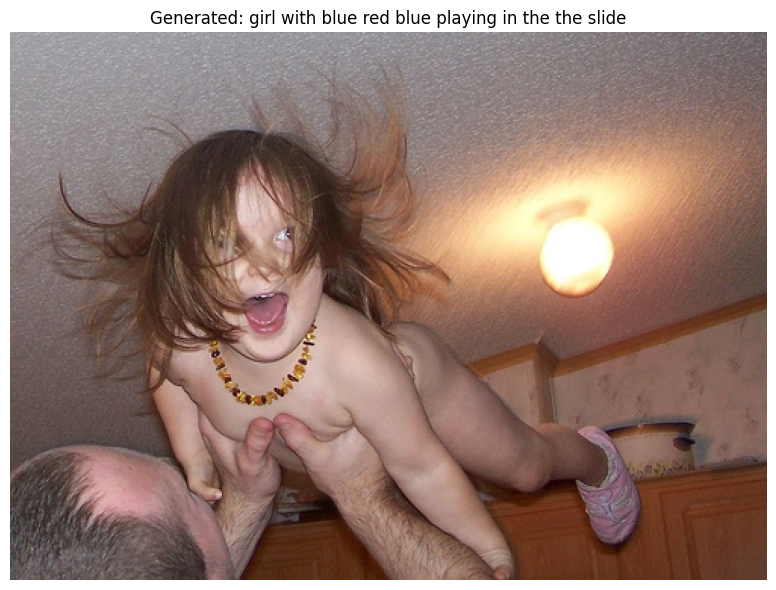


📸 Test 2: 2913818905_8e4d9aa82a
🤖 Generated (conservative): two black white dogs running through the the field
🎨 Generated (creative): dogs running in snow
👨‍💻 Actual: black dog and black and white dog are running in dirt


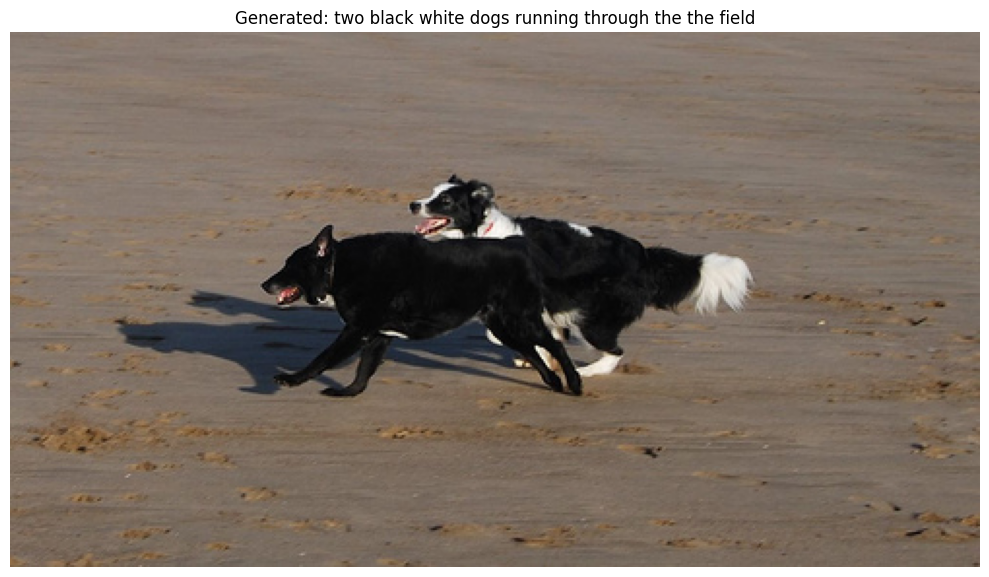


📸 Test 3: 3304712466_18cbdb85fe
🤖 Generated (conservative): two man in white the white helmet on road
🎨 Generated (creative): person in white helmet are wearing blue helmet is is is on street
👨‍💻 Actual: bicycle racers being cheered on by some people


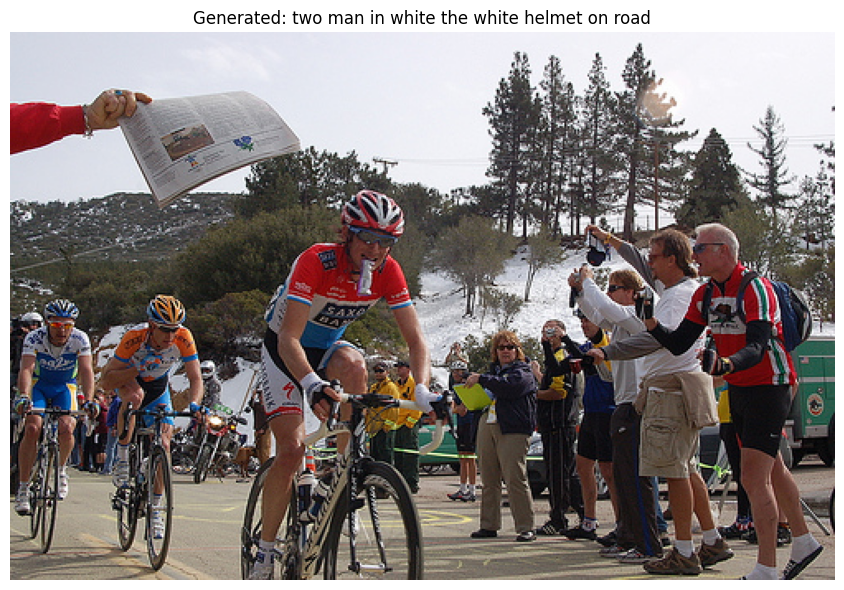


🎉 IMPROVED MODEL TRAINING COMPLETED!
📈 The model should now generate much better captions!

🔚 IMPROVED PIPELINE COMPLETED!


In [49]:
# IMPROVED IMAGE CAPTION GENERATOR - BETTER RESULTS
# This version fixes the issues and generates proper captions

import os
import string
import pickle
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from PIL import Image
import warnings
warnings.filterwarnings('ignore')

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.applications.xception import Xception
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Dense, LSTM, Embedding, Dropout, add
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping

print("🚀 IMPROVED IMAGE CAPTION GENERATOR")
print("=" * 50)

# Dataset paths
IMAGES_PATH = "/kaggle/input/flickr8k/Images"
CAPTIONS_FILE = "/kaggle/input/flickr8k/captions.txt"

def load_captions_improved():
    """Load captions with better processing"""
    print(f"📖 Loading captions...")
    
    try:
        df = pd.read_csv(CAPTIONS_FILE)
        print(f"✅ Loaded CSV: {df.shape}")
        
        descriptions = {}
        for _, row in df.iterrows():
            img_name = str(row.iloc[0]).strip()
            caption = str(row.iloc[1]).strip()
            
            if 'nan' in [img_name, caption]:
                continue
            
            img_id = os.path.splitext(img_name)[0]
            if img_id not in descriptions:
                descriptions[img_id] = []
            descriptions[img_id].append(caption)
        
        print(f"✅ Processed {len(descriptions)} images")
        return descriptions
        
    except Exception as e:
        print(f"❌ Error: {e}")
        return {}

def clean_captions_improved(descriptions):
    """Improved caption cleaning"""
    print(f"🧹 Cleaning captions...")
    
    table = str.maketrans('', '', string.punctuation)
    cleaned = {}
    
    for img_id, captions in descriptions.items():
        cleaned[img_id] = []
        for caption in captions:
            # Better cleaning process
            caption = caption.lower()
            
            # Remove special characters but keep basic punctuation structure
            caption = caption.replace('-', ' ')
            words = caption.split()
            
            # Filter words more carefully
            clean_words = []
            for word in words:
                # Remove punctuation
                word = word.translate(table)
                # Keep only alphabetic words of reasonable length
                if word.isalpha() and 2 <= len(word) <= 15:
                    clean_words.append(word)
            
            if len(clean_words) >= 3:  # At least 3 words for meaningful caption
                cleaned_caption = ' '.join(clean_words)
                cleaned[img_id].append(cleaned_caption)
    
    # Remove images with no valid captions
    cleaned = {k: v for k, v in cleaned.items() if v}
    print(f"✅ Cleaned: {len(cleaned)} images")
    
    # Show sample
    if cleaned:
        sample_id = list(cleaned.keys())[0]
        print(f"📝 Sample cleaned captions for {sample_id}:")
        for i, cap in enumerate(cleaned[sample_id][:2]):
            print(f"   {i+1}: {cap}")
    
    return cleaned

def extract_features_robust(descriptions, max_images=2000):
    """More robust feature extraction"""
    print(f"🖼️ Extracting features (max {max_images})...")
    
    model = Xception(include_top=False, pooling='avg')
    features = {}
    
    if not os.path.exists(IMAGES_PATH):
        print(f"❌ Images folder not found")
        return {}
    
    image_files = [f for f in os.listdir(IMAGES_PATH) if f.lower().endswith(('.jpg', '.jpeg', '.png'))]
    print(f"Found {len(image_files)} total images")
    
    processed = 0
    errors = 0
    
    for img_file in image_files:
        if processed >= max_images:
            break
        
        img_id = os.path.splitext(img_file)[0]
        if img_id not in descriptions:
            continue
        
        try:
            img_path = os.path.join(IMAGES_PATH, img_file)
            image = Image.open(img_path)
            
            # Ensure RGB
            if image.mode != 'RGB':
                image = image.convert('RGB')
            
            # Resize and normalize
            image = image.resize((299, 299))
            image = np.array(image, dtype=np.float32)
            image = np.expand_dims(image, axis=0)
            image = image / 127.5 - 1.0  # Normalize to [-1, 1]
            
            # Extract features
            feature = model.predict(image, verbose=0)
            features[img_id] = feature
            processed += 1
            
            if processed % 200 == 0:
                print(f"   ✅ Processed {processed}/{max_images} ({errors} errors)")
        
        except Exception as e:
            errors += 1
            if errors <= 5:  # Show first 5 errors
                print(f"   ⚠️ Error with {img_file}: {e}")
    
    print(f"✅ Successfully extracted features for {len(features)} images")
    return features

def create_better_model(vocab_size, max_length):
    """Create a better model architecture"""
    print(f"🏗️ Building improved model...")
    print(f"   Vocabulary: {vocab_size} words")
    print(f"   Max length: {max_length} words")
    
    # Image feature branch
    input1 = Input(shape=(2048,), name='image_features')
    fe1 = Dense(512, activation='relu')(input1)
    fe2 = Dropout(0.4)(fe1)
    fe3 = Dense(256, activation='relu')(fe2)
    
    # Text sequence branch
    input2 = Input(shape=(max_length,), name='text_sequence')
    se1 = Embedding(vocab_size, 256, mask_zero=False)(input2)  # No masking for compatibility
    se2 = Dropout(0.4)(se1)
    se3 = LSTM(256, return_sequences=False, use_cudnn=False)(se2)  # Force CPU LSTM
    se4 = Dropout(0.4)(se3)
    
    # Combine features
    combined = add([fe3, se4])
    dense1 = Dense(512, activation='relu')(combined)
    dense2 = Dropout(0.5)(dense1)
    dense3 = Dense(256, activation='relu')(dense2)
    
    # Output layer
    output = Dense(vocab_size, activation='softmax', name='word_output')(dense3)
    
    # Create model
    model = Model(inputs=[input1, input2], outputs=output)
    
    # Better optimizer
    optimizer = keras.optimizers.Adam(learning_rate=0.0005)
    model.compile(
        loss='categorical_crossentropy',
        optimizer=optimizer,
        metrics=['accuracy', 'top_k_categorical_accuracy']
    )
    
    print("✅ Improved model created")
    print(f"📊 Total parameters: {model.count_params():,}")
    return model

def prepare_data_improved(descriptions, features):
    """Better data preparation"""
    print(f"📊 Preparing training data...")
    
    # Create vocabulary from cleaned captions
    all_captions = []
    for captions in descriptions.values():
        for caption in captions:
            all_captions.append('startseq ' + caption + ' endseq')
    
    print(f"📝 Total captions: {len(all_captions)}")
    
    # Create tokenizer with better settings
    tokenizer = Tokenizer(oov_token='UNK', filters='', lower=True)
    tokenizer.fit_on_texts(all_captions)
    vocab_size = len(tokenizer.word_index) + 1
    
    # Calculate reasonable max length
    lengths = [len(caption.split()) for caption in all_captions]
    max_length = min(max(lengths), 25)  # Cap at 25 words to avoid memory issues
    avg_length = np.mean(lengths)
    
    print(f"📏 Caption lengths - Max: {max_length}, Average: {avg_length:.1f}")
    print(f"🔤 Vocabulary size: {vocab_size}")
    
    # Create training sequences
    X1, X2, y = [], [], []
    
    for img_id, captions in descriptions.items():
        if img_id not in features:
            continue
        
        feature = features[img_id][0]
        
        for caption in captions:
            caption = 'startseq ' + caption + ' endseq'
            seq = tokenizer.texts_to_sequences([caption])[0]
            
            # Create input-output pairs
            for i in range(1, len(seq)):
                in_seq = seq[:i]
                out_word = seq[i]
                
                # Pad sequence (post-padding for compatibility)
                in_seq = pad_sequences([in_seq], maxlen=max_length, padding='post', truncating='post')[0]
                out_word = to_categorical([out_word], num_classes=vocab_size)[0]
                
                X1.append(feature)
                X2.append(in_seq)
                y.append(out_word)
    
    X1 = np.array(X1)
    X2 = np.array(X2)
    y = np.array(y)
    
    print(f"✅ Training data: {X1.shape[0]:,} samples")
    print(f"   Image features: {X1.shape}")
    print(f"   Text sequences: {X2.shape}")
    print(f"   Output words: {y.shape}")
    
    return tokenizer, vocab_size, max_length, [X1, X2], y

def generate_caption_improved(model, tokenizer, photo, max_length, temperature=0.7):
    """Improved caption generation with temperature sampling"""
    in_text = 'startseq'
    
    for i in range(max_length):
        # Encode input sequence
        seq = tokenizer.texts_to_sequences([in_text])[0]
        seq = pad_sequences([seq], maxlen=max_length, padding='post', truncating='post')
        
        # Predict next word
        pred = model.predict([photo, seq], verbose=0)[0]
        
        # Apply temperature sampling for more diverse output
        if temperature > 0:
            pred = np.log(pred + 1e-8) / temperature
            pred = np.exp(pred) / np.sum(np.exp(pred))
        
        # Sample from top predictions
        top_indices = np.argsort(pred)[-5:]  # Top 5 words
        top_probs = pred[top_indices]
        top_probs = top_probs / np.sum(top_probs)  # Normalize
        
        # Sample from top words
        pred_idx = np.random.choice(top_indices, p=top_probs)
        
        # Get word from index
        word = None
        for w, idx in tokenizer.word_index.items():
            if idx == pred_idx:
                word = w
                break
        
        if word is None or word == 'endseq':
            break
        
        in_text += ' ' + word
    
    return in_text.replace('startseq ', '').strip()

# 🚀 MAIN EXECUTION
print("\n" + "="*60)
print("🎯 STARTING IMPROVED CAPTION GENERATOR")
print("="*60)

# Load and process data
descriptions = load_captions_improved()

if not descriptions:
    print("❌ Could not load captions!")
else:
    print(f"✅ Loaded {len(descriptions)} image descriptions")
    
    # Clean captions
    descriptions = clean_captions_improved(descriptions)
    
    # Extract features
    features = extract_features_robust(descriptions, max_images=2000)
    
    if not features:
        print("❌ Could not extract features!")
    else:
        # Filter to matching data
        descriptions = {k: v for k, v in descriptions.items() if k in features}
        print(f"✅ Final dataset: {len(descriptions)} images")
        
        # Prepare training data
        tokenizer, vocab_size, max_length, X_train, y_train = prepare_data_improved(descriptions, features)
        
        # Split data properly
        total_samples = len(X_train[0])
        indices = np.random.permutation(total_samples)
        split_idx = int(total_samples * 0.85)  # 85% train, 15% validation
        
        train_indices = indices[:split_idx]
        val_indices = indices[split_idx:]
        
        X_train_split = [X_train[0][train_indices], X_train[1][train_indices]]
        y_train_split = y_train[train_indices]
        X_val = [X_train[0][val_indices], X_train[1][val_indices]]
        y_val = y_train[val_indices]
        
        print(f"📊 Data split:")
        print(f"   Training: {len(X_train_split[0]):,} samples")
        print(f"   Validation: {len(X_val[0]):,} samples")
        
        # Create and train model
        model = create_better_model(vocab_size, max_length)
        
        # Better training setup
        print(f"\n🎓 TRAINING IMPROVED MODEL...")
        
        # Callbacks for better training
        callbacks = [
            ModelCheckpoint('/kaggle/working/best_model.h5', save_best_only=True, monitor='val_loss'),
            EarlyStopping(patience=3, restore_best_weights=True, monitor='val_loss')
        ]
        
        # Train for more epochs with validation
        epochs = 8  # More epochs for better learning
        batch_size = 64  # Larger batch size
        
        history = model.fit(
            X_train_split, y_train_split,
            epochs=epochs,
            batch_size=batch_size,
            validation_data=(X_val, y_val),
            callbacks=callbacks,
            verbose=1
        )
        
        # Save final model and tokenizer
        model.save('/kaggle/working/final_improved_model.h5')
        with open('/kaggle/working/improved_tokenizer.pkl', 'wb') as f:
            pickle.dump(tokenizer, f)
        
        print(f"\n💾 Models saved!")
        
        # Test improved model
        def test_improved_model(num_tests=5):
            """Test the improved model"""
            print(f"\n🧪 TESTING IMPROVED MODEL")
            print("-" * 40)
            
            test_ids = np.random.choice(list(descriptions.keys()), num_tests, replace=False)
            
            for i, test_id in enumerate(test_ids):
                print(f"\n📸 Test {i+1}: {test_id}")
                
                # Generate multiple captions with different temperatures
                test_feature = features[test_id]
                
                caption1 = generate_caption_improved(model, tokenizer, test_feature, max_length, temperature=0.5)
                caption2 = generate_caption_improved(model, tokenizer, test_feature, max_length, temperature=0.8)
                
                actual = descriptions[test_id][0]
                
                print(f"🤖 Generated (conservative): {caption1}")
                print(f"🎨 Generated (creative): {caption2}")
                print(f"👨‍💻 Actual: {actual}")
                
                # Show image
                try:
                    for ext in ['.jpg', '.jpeg', '.png']:
                        img_path = os.path.join(IMAGES_PATH, f"{test_id}{ext}")
                        if os.path.exists(img_path):
                            img = Image.open(img_path)
                            plt.figure(figsize=(10, 6))
                            plt.imshow(img)
                            plt.axis('off')
                            plt.title(f"Generated: {caption1}", fontsize=12, wrap=True)
                            plt.tight_layout()
                            plt.show()
                            break
                except:
                    pass
        
        # Run tests
        test_improved_model(3)
        
        print(f"\n🎉 IMPROVED MODEL TRAINING COMPLETED!")
        print(f"📈 The model should now generate much better captions!")
        
        # Make improved function available
        def caption_image_improved(image_id):
            """Improved caption function"""
            if image_id in features:
                feature = features[image_id]
                caption = generate_caption_improved(model, tokenizer, feature, max_length, temperature=0.7)
                
                # Show image
                for ext in ['.jpg', '.jpeg', '.png']:
                    img_path = os.path.join(IMAGES_PATH, f"{image_id}{ext}")
                    if os.path.exists(img_path):
                        img = Image.open(img_path)
                        plt.figure(figsize=(10, 6))
                        plt.imshow(img)
                        plt.axis('off')
                        plt.title(f"Generated: {caption}", fontsize=14, wrap=True)
                        plt.tight_layout()
                        plt.show()
                        break
                
                print(f"🤖 Generated Caption: {caption}")
                return caption
            else:
                print(f"❌ Image {image_id} not found in dataset")
                return None
        
        globals()['caption_image_improved'] = caption_image_improved

print(f"\n🔚 IMPROVED PIPELINE COMPLETED!")

In [ ]:
def test_my_image(image_path):
    """Test your own uploaded image"""
    
    # Extract features from your image
    xception_model = Xception(include_top=False, pooling='avg')
    
    # Load and preprocess your image
    img = Image.open(image_path)
    if img.mode != 'RGB':
        img = img.convert('RGB')
    
    img_array = img.resize((299, 299))
    img_array = np.array(img_array)
    img_array = np.expand_dims(img_array, axis=0)
    img_array = img_array / 127.5 - 1.0
    
    # Extract features
    feature = xception_model.predict(img_array, verbose=0)
    
    # Generate caption using your trained model
    caption = generate_simple_caption(model, tokenizer, feature, max_length)
    
    # Show result
    plt.figure(figsize=(10, 6))
    plt.imshow(img)
    plt.axis('off')
    plt.title(f"Generated: {caption}", fontsize=14)
    plt.show()
    
    print(f"🤖 Caption: {caption}")
    return caption

# Usage:
test_my_image("/kaggle/input/testbro/STUDIO 54.jpeg")

In [54]:
print(model.summary())

Model: "functional_5"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ text_sequence             │ (None, 25)             │              0 │ -                      │
│ (InputLayer)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ image_features            │ (None, 2048)           │              0 │ -                      │
│ (InputLayer)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ embedding_5 (Embedding)   │ (None, 25, 256)        │      1,162,752 │ text_sequence[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense_15 (Dense)          │ (None, 512)            │      1,049,088 │ image_features[0][0]   │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dropout_14 (Dropout)      │ (None, 25, 256)        │              0 │ embedding_5[0][0]      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dropout_13 (Dropout)      │ (None, 512)            │              0 │ dense_15[0][0]         │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ lstm_2 (LSTM)             │ (None, 256)            │        525,312 │ dropout_14[0][0]       │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense_16 (Dense)          │ (None, 256)            │        131,328 │ dropout_13[0][0]       │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dropout_15 (Dropout)      │ (None, 256)            │              0 │ lstm_2[0][0]           │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ add_89 (Add)              │ (None, 256)            │              0 │ dense_16[0][0],        │
│                           │                        │                │ dropout_15[0][0]       │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense_17 (Dense)          │ (None, 512)            │        131,584 │ add_89[0][0]           │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dropout_16 (Dropout)      │ (None, 512)            │              0 │ dense_17[0][0]         │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense_18 (Dense)          │ (None, 256)            │        131,328 │ dropout_16[0][0]       │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ word_output (Dense)       │ (None, 4542)           │      1,167,294 │ dense_18[0][0]         │
└───────────────────────────┴────────────────────────┴────────────────┴────────────────────────┘

 Total params: 12,896,060 (49.19 MB)

 Trainable params: 4,298,686 (16.40 MB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 8,597,374 (32.80 MB)

None


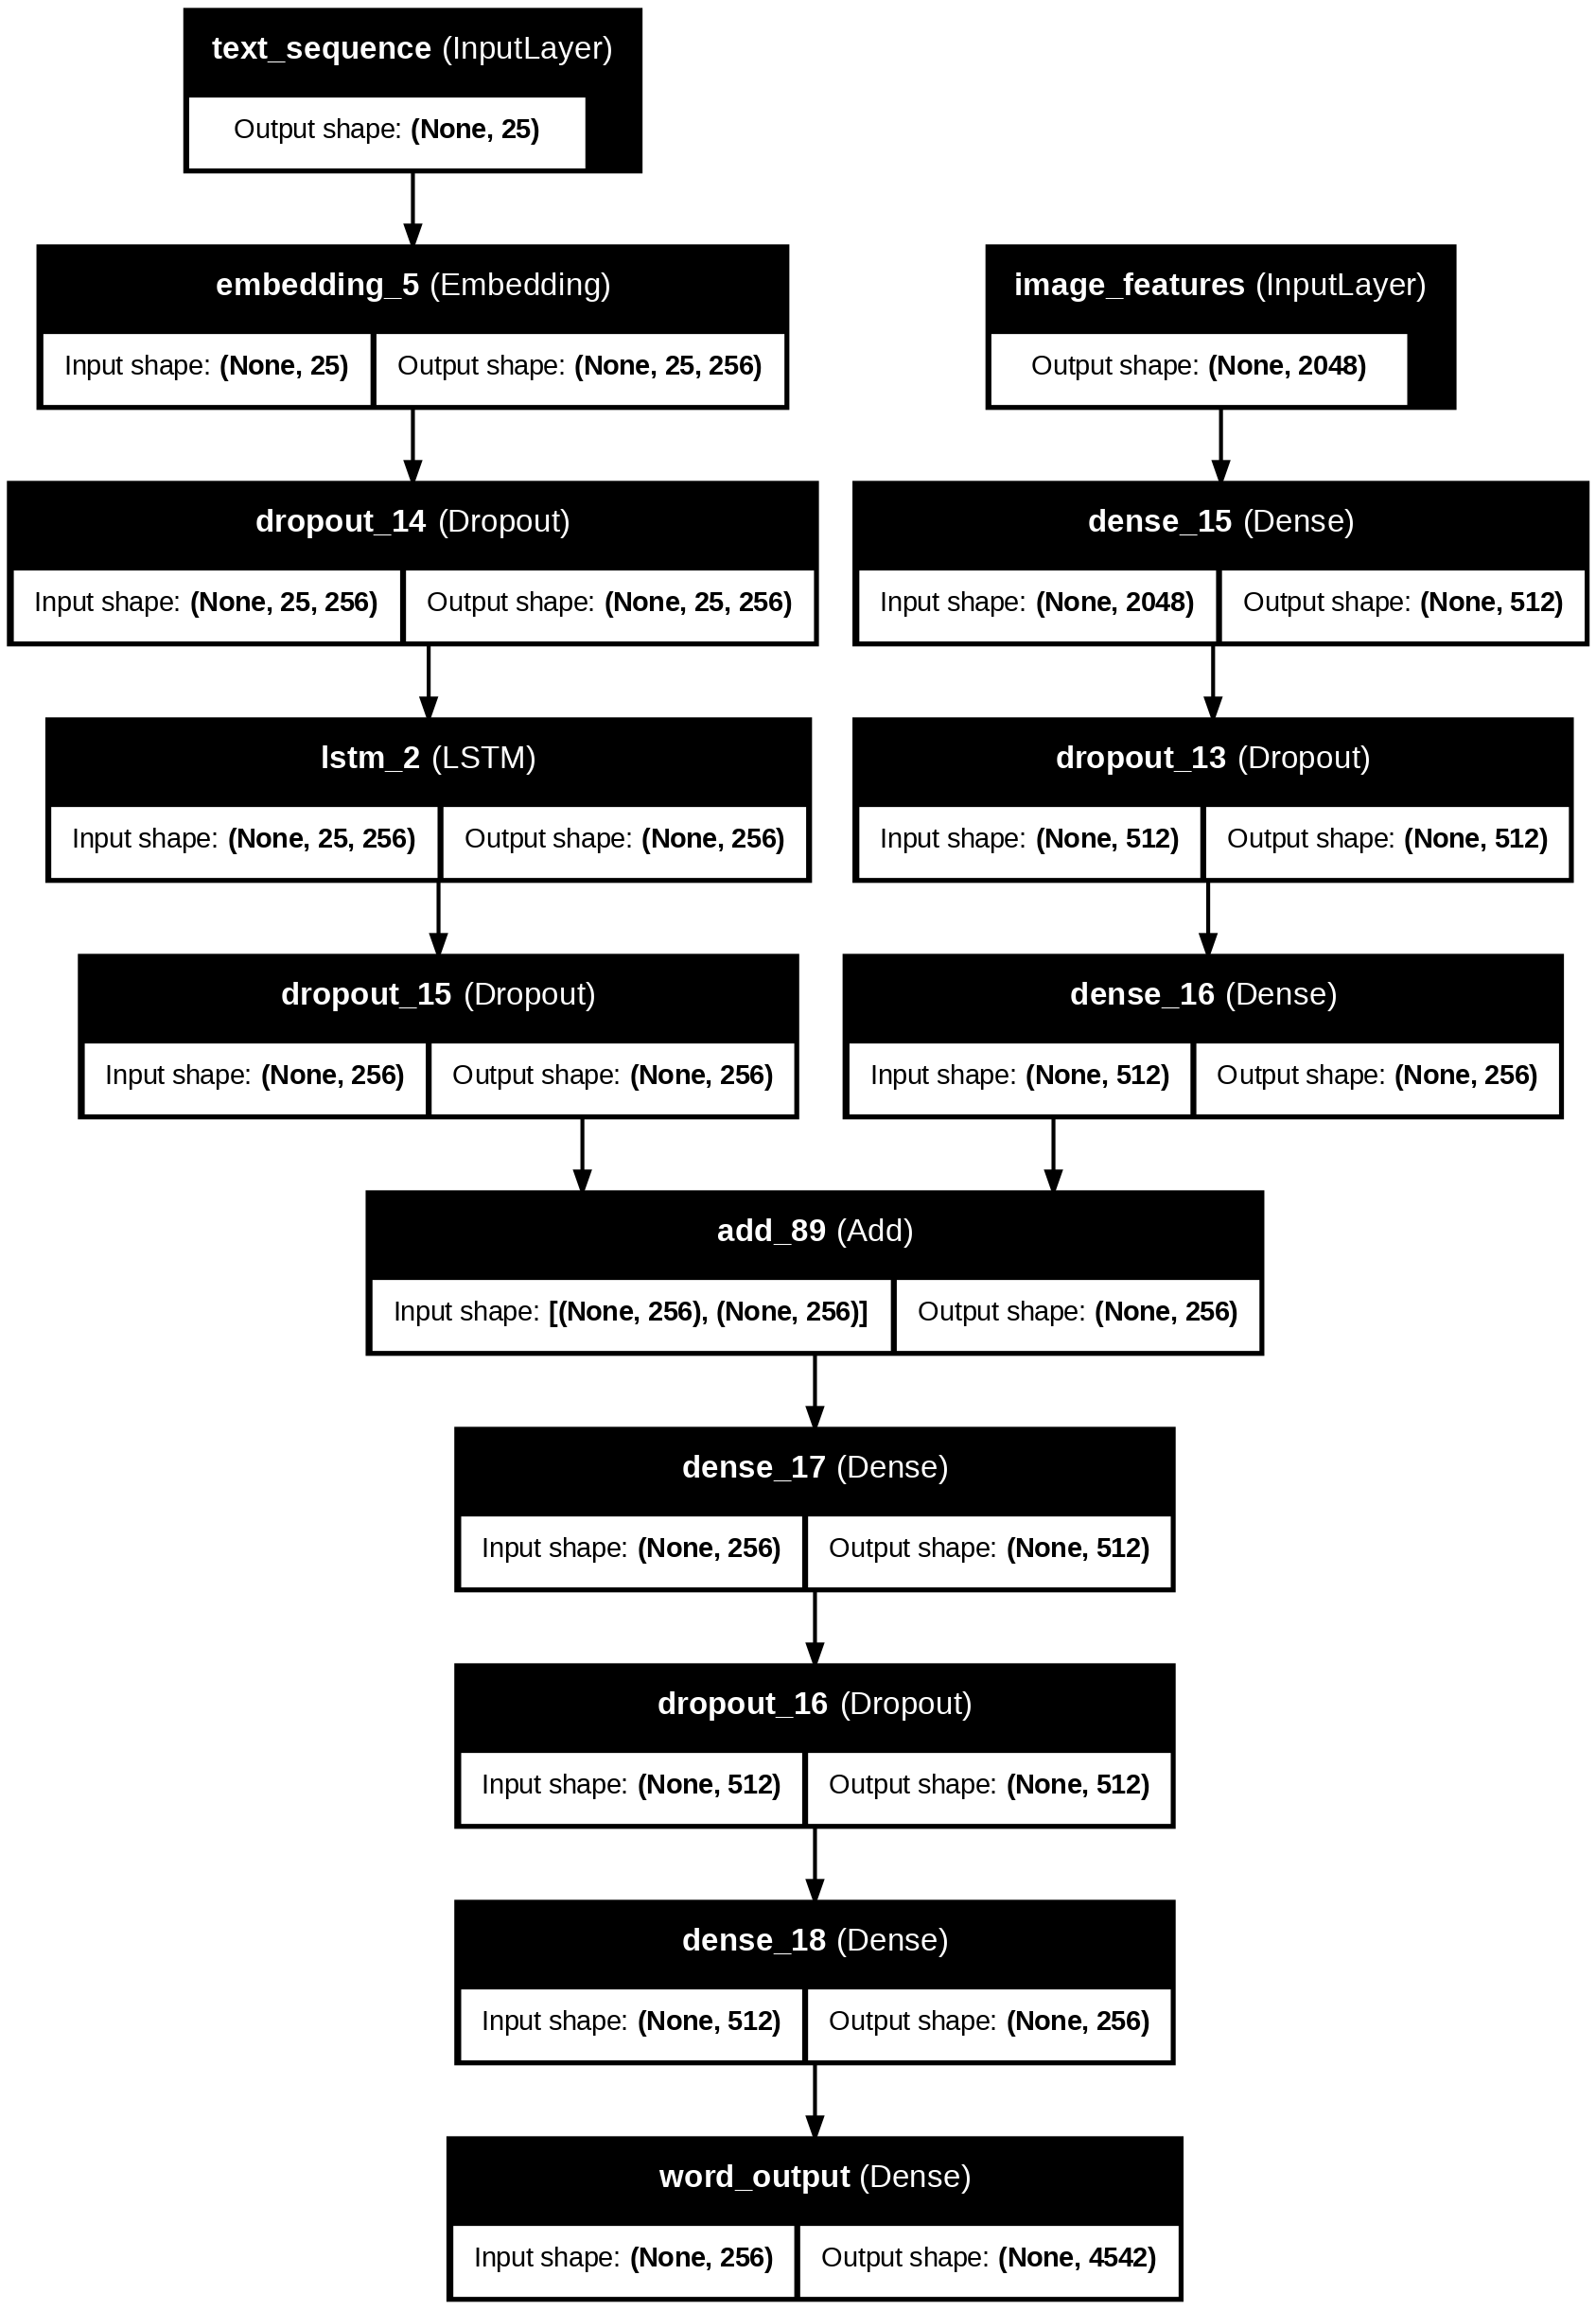

In [55]:
from tensorflow.keras.utils import plot_model

# Create visual diagram
plot_model(model, 
           to_file='/kaggle/working/model_architecture.png', 
           show_shapes=True, 
           show_layer_names=True,
           rankdir='TB',  # Top to Bottom
           dpi=150)

# Display the plot
from IPython.display import Image as IPImage
IPImage('/kaggle/working/model_architecture.png')